In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue

from tbu_gym.tbu_discrete import TruckBackerEnv_D

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-5, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        # device, not needed, but needed if going on canada compute to specify gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.q_nn = self.build_nn().to(self.device) # build q network
        self.target_net = self.build_nn().to(self.device) # build target network
        self.target_net.load_state_dict(self.q_nn.state_dict()) # make target net same as q net. initialization is random so need this
        self.optimizer = optim.Adam(self.q_nn.parameters(), lr=lr) 
        
    def build_nn(self): # to build the q network, 2 hiddne layer with relu and 128 neuronsin each
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )
    
    def agent_policy(self, state): # act e greedy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim) # rand action
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device) # convert state to tensor, then add batch dimension, then move to device
        with torch.no_grad(): # dont calculate gradients, no need
            q_values = self.q_nn(state)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # store transition sars, done is if terminal state
    
    def train_with_mem(self): # train with experience from memory using batch size set in agent
        if len(self.memory) < self.batch_size: # if not enought mem, could be changed to use what we have instead of skip
            return
        batch = random.sample(self.memory, self.batch_size) # get batch
        states, actions, rewards, next_states, dones = zip(*batch) # get batch features

        # convert data to tensors which can be used by pytorch
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device) 
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # get current q values from q network
        q_values = self.q_nn(states).gather(1, actions)

        # use the samples from experience batch to calc target network q values
        with torch.no_grad(): # no need to calc gradients for target
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]  
        # target = r + gamma * max_a' Q(s', a') * (1 - done)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        # mean squared error 
        errors = target - q_values
        squared_errors = errors ** 2
        mean_squared_error = torch.mean(squared_errors)

        self.optimizer.zero_grad()
        mean_squared_error.backward()
        self.optimizer.step()
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

    
    def update_target(self): # update target network replacing it with the current q network
        self.target_net.load_state_dict(self.q_nn.state_dict())

Episode 1, Reward: -300, Epsilon: 0.993
Episode 2, Reward: -300, Epsilon: 0.984
Episode 3, Reward: -300, Epsilon: 0.975
Episode 4, Reward: -300, Epsilon: 0.966
Episode 5, Reward: -300, Epsilon: 0.958
Episode 6, Reward: -300, Epsilon: 0.949
Episode 7, Reward: -300, Epsilon: 0.941
Episode 8, Reward: -300, Epsilon: 0.932
Episode 9, Reward: -300, Epsilon: 0.924
Episode 10, Reward: -300, Epsilon: 0.916
Episode 11, Reward: -300, Epsilon: 0.907
Episode 12, Reward: -300, Epsilon: 0.899
Episode 13, Reward: -300, Epsilon: 0.891
Episode 14, Reward: -300, Epsilon: 0.883
Episode 15, Reward: -300, Epsilon: 0.875
Episode 16, Reward: -300, Epsilon: 0.868
Episode 17, Reward: -300, Epsilon: 0.860
Episode 18, Reward: -300, Epsilon: 0.852
Episode 19, Reward: 45, Epsilon: 0.851
Episode 20, Reward: -300, Epsilon: 0.843
Episode 21, Reward: -300, Epsilon: 0.835
Episode 22, Reward: -300, Epsilon: 0.828
Episode 23, Reward: -300, Epsilon: 0.821
Episode 24, Reward: -300, Epsilon: 0.813
Episode 25, Reward: -300, E

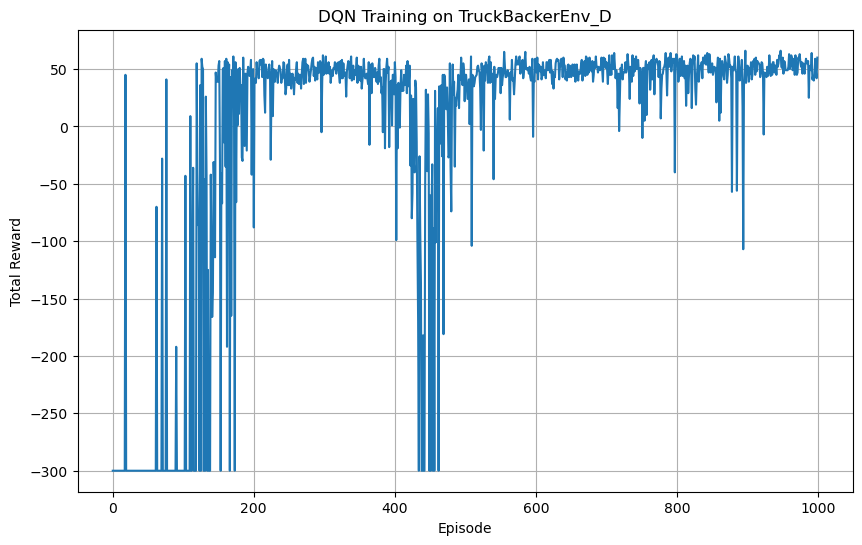

In [24]:
import numpy as np
from tbu_gym.tbu_discrete import TruckBackerEnv_D
import matplotlib.pyplot as plt

#hyper params, these are set by default in the agent but can be changed here
num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5

#agent env setup
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    batch_size=batch_size
)

#training
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0

    for t in range(max_steps_per_episode):
  
        action = agent.agent_policy(state) # e greedy action
  
        # step env
        next_state, reward, done, info = env.step(action) # do a observe s',r and if terminal
        total_reward += reward

        #store transition in memory
        agent.remember(state, action, reward, next_state, done) # set s' = s a r and if terminal

        # train agent with memory, will train with batch size set in agent
        agent.train_with_mem() 

        state = next_state #s = s'

        if done: # if terminal state
            break


    if episode % target_update_freq == 0:
        agent.update_target()

    episode_rewards.append(total_reward)
    
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")



plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('DQN_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()


In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt


# --- 1. QRC Network Definition ---
class QRCNetwork(nn.Module):
    """
    A simple MLP for the Q-value function.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QRCNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# --- 2. QRC Agent Implementation ---
class QRCAgent:
    """
    Q-learning with Regularized Corrections (QRC) Agent.
    """
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.995, batch_size=64, 
                 memory_size=5000, target_update_freq=10,
                 # QRC Specific Parameters
                 alpha=1.0, sigma_min=0.0, sigma_max=1.0):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.train_step = 0

        # QRC parameters
        self.alpha = alpha
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QRCNetwork(state_dim, action_dim).to(self.device)
        self.target_network = QRCNetwork(state_dim, action_dim).to(self.device)
        self.update_target()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def agent_policy(self, state):
        """Selects action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
            
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        """Stores a transition in the replay memory."""
        self.memory.append((state, action, reward, next_state, done))

    def train_with_mem(self):
        """Trains the Q-Network using a batch from the replay memory (QRC loss)."""
        if len(self.memory) < self.batch_size:
            return 0.0 # Return 0 loss if not training
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to Tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # 1. Predicted Q-values for current states Q(S, A)
        q_values = self.q_network(states).gather(1, actions)
        
        # --- 2. Calculate the QRC Target (Y_QRC) ---
        with torch.no_grad():
            # a) Standard DQN Target calculation (using Target Network)
            q_next_target_max = self.target_network(next_states).max(1)[0].unsqueeze(1)
            q_target_dqn = rewards + self.gamma * q_next_target_max * (1 - dones)
            
            # b) QRC Correction Term Calculation (using Online Network)
            q_next_online_all_actions = self.q_network(next_states) 
            
            # Calculate standard deviation of Q(S', a') across actions a'
            q_std = torch.std(q_next_online_all_actions, dim=1, keepdim=True)
            
            # Apply clipping [sigma_min, sigma_max]
            q_std_clipped = torch.clamp(q_std, self.sigma_min, self.sigma_max)

            # Correction term: alpha * clipped_std
            correction_term = self.alpha * q_std_clipped
            
            # c) Final QRC Target: Y_QRC = Y_DQN - Correction Term
            q_target_qrc = q_target_dqn - correction_term

        # 3. Compute loss: MSE(Q(S, A), Y_QRC)
        loss = self.loss_fn(q_values, q_target_qrc)
        
        # 4. Optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()

    def update_target(self):
        """Updates the target network weights by copying the Q-network weights."""
        self.target_network.load_state_dict(self.q_network.state_dict())


Episode 1/1000, Reward: -300.00, Epsilon: 0.99292, Loss: 0.00313
Episode 2/1000, Reward: -300.00, Epsilon: 0.98402, Loss: 0.00146
Episode 3/1000, Reward: -300.00, Epsilon: 0.97520, Loss: 0.00090
Episode 4/1000, Reward: -300.00, Epsilon: 0.96646, Loss: 0.00126
Episode 5/1000, Reward: -300.00, Epsilon: 0.95781, Loss: 0.00164
Episode 6/1000, Reward: -300.00, Epsilon: 0.94922, Loss: 0.00698
Episode 7/1000, Reward: -300.00, Epsilon: 0.94072, Loss: 0.00109
Episode 8/1000, Reward: -300.00, Epsilon: 0.93229, Loss: 0.01077
Episode 9/1000, Reward: -300.00, Epsilon: 0.92394, Loss: 0.00112
Episode 10/1000, Reward: -300.00, Epsilon: 0.91566, Loss: 0.00423
Episode 11/1000, Reward: -300.00, Epsilon: 0.90745, Loss: 0.00160
Episode 12/1000, Reward: -300.00, Epsilon: 0.89932, Loss: 0.00328
Episode 13/1000, Reward: -300.00, Epsilon: 0.89127, Loss: 0.00204
Episode 14/1000, Reward: -300.00, Epsilon: 0.88328, Loss: 0.03475
Episode 15/1000, Reward: -300.00, Epsilon: 0.87537, Loss: 0.04882
Episode 16/1000, Re

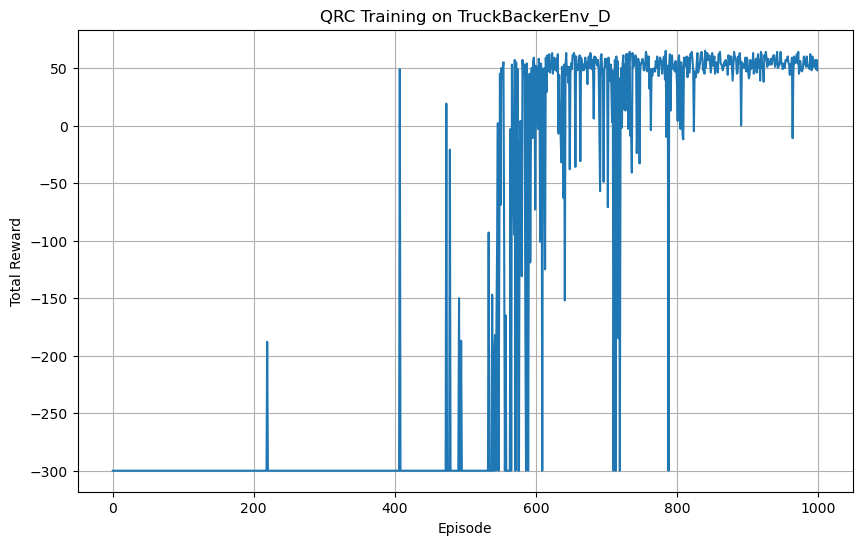

In [26]:
from tbu_gym.tbu_discrete import TruckBackerEnv_D

# --- 3. Training Script Setup and Execution ---

# Hyperparameters (user-defined and QRC-specific)
num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5 # Target network update frequency in episodes

# QRC Specific Parameters (Defaults)
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0


# Environment Setup
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Agent Initialization (using QRCAgent)
agent = QRCAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    batch_size=batch_size,
    target_update_freq=target_update_freq,
    alpha=alpha,
    sigma_min=sigma_min,
    sigma_max=sigma_max
)

# Training Loop
episode_rewards = []
recent_loss = 0.0 # Variable to track latest loss for printing

for episode in range(1, num_episodes + 1):
    # env.reset returns a tuple in modern gyms, ensure it's unpacked correctly
    state, info = env.reset() if isinstance(env.reset(), tuple) else (env.reset(), {})
    total_reward = 0

    for t in range(max_steps_per_episode):
        
        action = agent.agent_policy(state)
        
        # Check if environment step returns a tuple of (next_state, reward, terminated, truncated, info) or (next_state, reward, done, info)
        step_result = env.step(action)
        
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else: # assuming old gym signature (next_state, reward, done, info)
            next_state, reward, done, info = step_result

        total_reward += reward

        # Store transition in memory
        agent.remember(state, action, reward, next_state, done)

        # Train agent with memory
        current_loss = agent.train_with_mem()
        if current_loss != 0.0:
            recent_loss = current_loss

        state = next_state

        if done:
            break

    # Target Network Update (based on episode count)
    if episode % target_update_freq == 0:
        agent.update_target()

    episode_rewards.append(total_reward)
    
    # Print episode summary
    print(f"Episode {episode}/{num_episodes}, Reward: {total_reward:6.2f}, Epsilon: {agent.epsilon:.5f}, Loss: {recent_loss:.5f}")


# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()